In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch

from iwp.algorithms.algorithms import (
    FISTA,
    ForwardBackward,
    GradientDescent,
    NesterovAcceleratedGradientDescent,
    StronglyConvexNesterovAcceleratedGradientDescent,
)
from iwp.algorithms.plot import plot_all_algorithms_convergence
from iwp.algorithms.metrics import mae, mse
from iwp.data.load_experiment_data import load_experiment_data
from iwp.data.export import save_complex_vector
from iwp.utils.config import load_yaml_into_namespace
from iwp.utils.logger import setup_logger
from iwp.utils.utils import copy_file, make_dirs, set_seed

In [2]:
from types import SimpleNamespace
args = SimpleNamespace(
    config = os.path.join(os.getcwd(), "config.yaml"),
)
args = load_yaml_into_namespace(args.config, args)

# Paths to save the results
args.exp_path, args.visuals_path, args.results_path = make_dirs(
    os.path.join(args.exp_path, args.exp_name)
)

logger = setup_logger(
    name="iwp",
    log_file=(
        os.path.join(args.exp_path, f"{args.exp_name}.log")
        if args.save_logs
        else None
    ),
    level=args.log_level,
    log_to_console=args.log_to_console,
)
verbose = args.verbose

# Save the config file in the experiment folder
copy_file(args.config, os.path.join(args.exp_path, "config.yaml"))

# Setup device and seed
if args.device == "cuda" and not torch.cuda.is_available():
    logger.warning("CUDA is not available. Falling back to CPU.")
    args.device = "cpu"
if args.device not in ["cpu", "cuda"]:
    raise ValueError("Device must be either 'cpu' or 'cuda'.")
logger.info(f"Using device: {args.device}")
set_seed(args.seed)

# Load data
A, B_list, C, d_list, m = load_experiment_data(args.data_path)
A_star = A.conj().T
C_star = C.conj().T

I = len(B_list)
J, L = C.shape
P = B_list[0].shape[1]
logger.info(f"Dimensions: I={I}, J={J}, L={L}, P={P}")

row_blocks = []
for i in range(I):
    blocks = [sp.csr_matrix((J, L))] * I + [sp.csr_matrix((J, P))]
    blocks[i] = sp.csr_matrix(C)
    row_blocks.append(sp.hstack(blocks, format="csr"))
D = sp.vstack(
    row_blocks, format="csr"
)  # shape: (I*J, I*L + P) if A is (L,L), B_i is (L,P)
D_star = D.conj().T

d = np.concatenate(d_list, axis=0)  # shape: (I*J,)

row_blocks = []
for i in range(I):
    blocks = [sp.csr_matrix((L, L))] * I + [-B_list[i]]
    blocks[i] = sp.csr_matrix(A)
    row_blocks.append(sp.hstack(blocks, format="csr"))
E = sp.vstack(row_blocks, format="csr")  # shape: (I*L, I*L + P)
E_star = E.conj().T

lambd = float(args.lambd)
mu = float(args.mu)

K_eigenvalues_A = np.linalg.eigvals((A.conj().T @ A).toarray())
K_A = np.max(np.abs(K_eigenvalues_A))
logger.info(f"Lipschitz constant K_A: {K_A}")

def J_1(x):
    Dx_minus_d = D @ x - d
    Ex = E @ x
    return (
        0.5 * np.vdot(Dx_minus_d, Dx_minus_d).real
        + 0.5 * lambd * np.vdot(Ex, Ex).real
        + 0.5 * mu * np.vdot(x, x).real
    )

def dJ_1(x):
    Dx_minus_d = D @ x - d
    Ex = E @ x
    return D.conj().T @ Dx_minus_d + lambd * E_star @ Ex + mu * x

K_op_J_1 = D.conj().T @ D + lambd * E_star @ E + mu * sp.eye(I * L + P)
K_eigenvalues_J_1 = np.linalg.eigvals(K_op_J_1.toarray())
K_J_1 = np.max(np.abs(K_eigenvalues_J_1))
logger.info(f"Lipschitz constant K_J_1: {K_J_1}")

def J_2(x, threshold=1e-6):
    Dx_minus_d = D @ x - d
    Ex = E @ x
    if np.linalg.norm(Ex) < threshold:
        return (
            0.5 * np.vdot(Dx_minus_d, Dx_minus_d).real
            + 0.5 * mu * np.vdot(x[-P:], x[-P:]).real
        )
    else:
        return np.inf

def grad_J_2(x):
    reg = np.zeros_like(x)
    reg[-P:] = mu * x[-P:]
    return D_star @ (D @ x - d) + reg

def prox_J_2(x, gamma):
    w = sp.linalg.spsolve(E @ E_star, E @ x)
    return x - E_star @ w

K_op_J_2 = D.conj().T @ D + mu * sp.eye(I * L + P)
K_eigenvalues_J_2 = np.linalg.eigvals(K_op_J_2.toarray())
K_J_2 = np.max(np.abs(K_eigenvalues_J_2))
logger.info(f"Lipschitz constant K_J_2: {K_J_2}")

def J_3(m):
    total = 0.0
    for i in range(I):
        CA_inv_Bi_m = C @ sp.linalg.spsolve(A, B_list[i] @ m)
        diff = CA_inv_Bi_m - d_list[i]
        total += 0.5 * np.vdot(diff, diff).real
    return total + 0.5 * mu * np.vdot(m, m).real

def dJ_3(m):
    p_sum = sum(
        B_i.conj().T
        @ sp.linalg.spsolve(
            A_star,
            C_star @ (C @ sp.linalg.spsolve(A, B_i @ m) - d_i),
        )
        for B_i, d_i in zip(B_list, d_list)
    )
    return p_sum + mu * m

Ainv = sp.linalg.inv(A.tocsc())
K_op_J_3 = sum(
    B_i.conj().T @ Ainv.conj().T @ C.conj().T @ C @ Ainv @ B_i for B_i in B_list
) + mu * sp.eye(P)
K_eigenvalues_J_3 = np.linalg.eigvals(K_op_J_3.toarray())
K_J_3 = np.max(np.abs(K_eigenvalues_J_3))
logger.info(f"Lipschitz constant K_J_3: {K_J_3}")

x_0 = np.zeros(I * L + P, dtype=np.complex128)  # shape: (I*L + P,)

2025-09-14 07:53:22 - iwp - INFO - Using device: cpu
2025-09-14 07:53:22 - iwp - INFO - Set seed for all random number generators to seed 42
2025-09-14 07:53:22 - iwp - INFO - Found 2 B matrices.
2025-09-14 07:53:22 - iwp - INFO - Loaded data.
2025-09-14 07:53:22 - iwp - INFO - Dimensions: I=2, J=50, L=223, P=394
2025-09-14 07:53:22 - iwp - INFO - Lipschitz constant K_A: 43.67755886947963
2025-09-14 07:53:23 - iwp - INFO - Lipschitz constant K_J_1: 5.090999419167316
2025-09-14 07:53:23 - iwp - INFO - Lipschitz constant K_J_2: 5.089197871576659
2025-09-14 07:53:23 - iwp - INFO - Lipschitz constant K_J_3: 0.5827462612350582


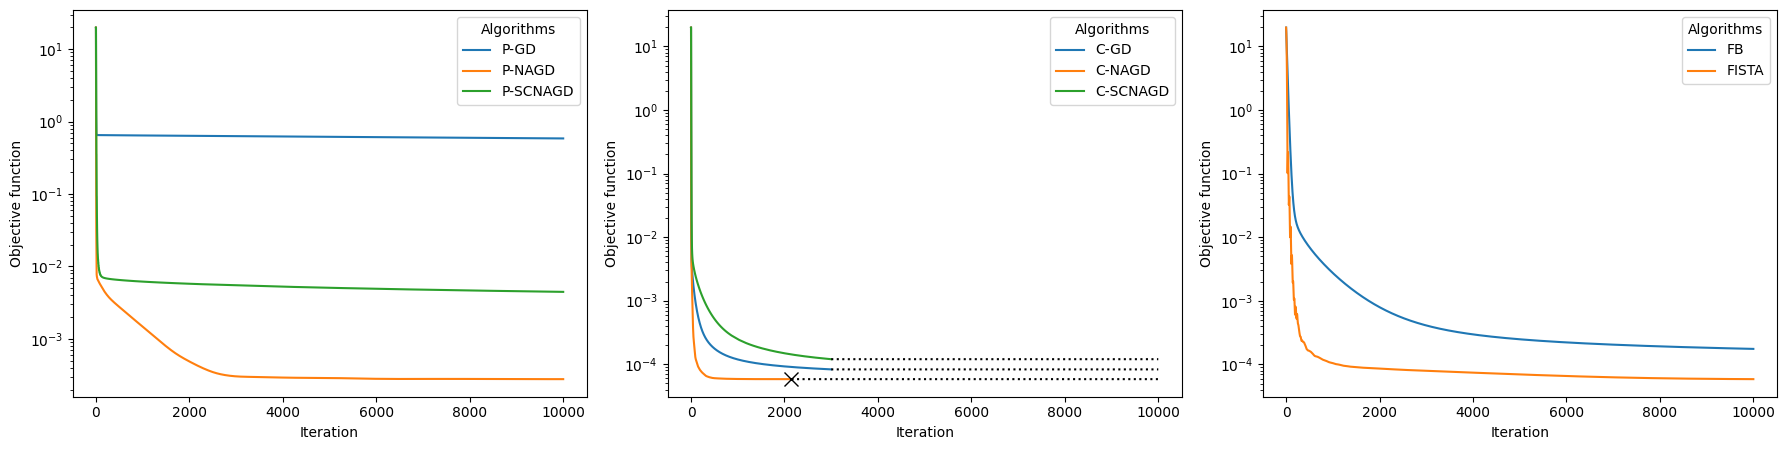

In [ ]:
algo_1 = GradientDescent(
    exp_name=args.exp_name,
    algo_plot_name="P-GD",
    f=J_1,
    df=dJ_1,
    K=K_J_1,
    gamma=2.0 / K_J_1 - 1e-6,
    logger=logger,
    verbose=verbose,
)
x = algo_1.run(x0=x_0, max_iterations=10000)
algo_1.plot_algorithm_convergence(m, args.visuals_path, show=False, save=False)

algo_2 = NesterovAcceleratedGradientDescent(
    exp_name=args.exp_name,
    algo_plot_name="P-NAGD",
    f=J_1,
    df=dJ_1,
    K=K_J_1,
    logger=logger,
    verbose=verbose,
)
algo_2.run(x0=x_0, max_iterations=10000)
algo_2.plot_algorithm_convergence(m, args.visuals_path, show=False, save=False)

algo_3 = StronglyConvexNesterovAcceleratedGradientDescent(
    exp_name=args.exp_name,
    algo_plot_name="P-SCNAGD",
    f=J_1,
    df=dJ_1,
    K=K_J_1,
    mu=mu,
    logger=logger,
    verbose=verbose,
)
algo_3.run(x0=x_0, max_iterations=10000)
algo_3.plot_algorithm_convergence(m, args.visuals_path, show=False, save=False)

algo_4 = ForwardBackward(
    exp_name=args.exp_name,
    algo_plot_name="FB",
    f=J_2,
    grad=grad_J_2,
    prox=prox_J_2,
    gamma=2.0 / K_J_2 - 1e-6,
    lambd=1,
    logger=logger,
    verbose=verbose,
)
algo_4.run(x0=x_0, max_iterations=10000)
algo_4.plot_algorithm_convergence(m, args.visuals_path, show=False, save=False)

algo_5 = FISTA(
    exp_name=args.exp_name,
    algo_plot_name="FISTA",
    f=J_2,
    grad=grad_J_2,
    prox=prox_J_2,
    K=K_J_2,
    logger=logger,
    verbose=verbose,
)
algo_5.run(x0=x_0, max_iterations=10000)
algo_5.plot_algorithm_convergence(m, args.visuals_path, show=False, save=False)

algo_6 = GradientDescent(
    exp_name=args.exp_name,
    algo_plot_name="C-GD",
    f=J_3,
    df=dJ_3,
    K=K_J_3,
    gamma=2.0 / K_J_3 - 8e-1,
    logger=logger,
    verbose=verbose,
)
algo_6.run(x0=x_0[-P:], max_iterations=3000)
algo_6.plot_algorithm_convergence(m, args.visuals_path, show=False, save=False)

algo_7 = NesterovAcceleratedGradientDescent(
    exp_name=args.exp_name,
    algo_plot_name="C-NAGD",
    f=J_3,
    df=dJ_3,
    K=K_J_3,
    logger=logger,
    verbose=verbose,
)
algo_7.run(x0=x_0[-P:], max_iterations=3000)
algo_7.plot_algorithm_convergence(m, args.visuals_path, show=False, save=False)

algo_8 = StronglyConvexNesterovAcceleratedGradientDescent(
    exp_name=args.exp_name,
    algo_plot_name="C-SCNAGD",
    f=J_3,
    df=dJ_3,
    K=K_J_3,
    mu=mu,
    logger=logger,
    verbose=verbose,
)
algo_8.run(x0=x_0[-P:], max_iterations=3000)
algo_8.plot_algorithm_convergence(m, args.visuals_path, show=False, save=False)


def plot_objective_functions_by_algorithm(list_of_algo_lists, add_marker=False):
    fig, axs  = plt.subplots(1, len(list_of_algo_lists), figsize=(18, 5))
    for idx, algo_list in enumerate(list_of_algo_lists):
        for algo in algo_list:
            label_name = algo.algo_plot_name
            values = algo.f_values
            iters = len(values)
            axs[idx].plot(
                range(iters),
                values,
                label=label_name,
                marker="o" if add_marker else None,
                markersize=4 if add_marker else None,
            )
            if iters < algo.max_iterations:
                axs[idx].plot(
                    iters - 1,
                    values[-1],
                    marker="x",
                    color="black",
                    markersize=10,
                )
            if iters < 10000:
                axs[idx].plot(
                    range(iters - 1, 10000),
                    [values[-1]] * (10000 - iters + 1),
                    linestyle=":",
                    color="black",
                )
        axs[idx].set_xlabel("Iteration")
        axs[idx].set_ylabel("Objective function")
        axs[idx].set_yscale("log")
        axs[idx].legend(
            loc="upper right",
            title="Algorithms"
        )
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_objective_functions_by_algorithm(
    [
        [algo_1, algo_2, algo_3],
        [algo_6, algo_7, algo_8],
        [algo_4, algo_5],
    ],
)

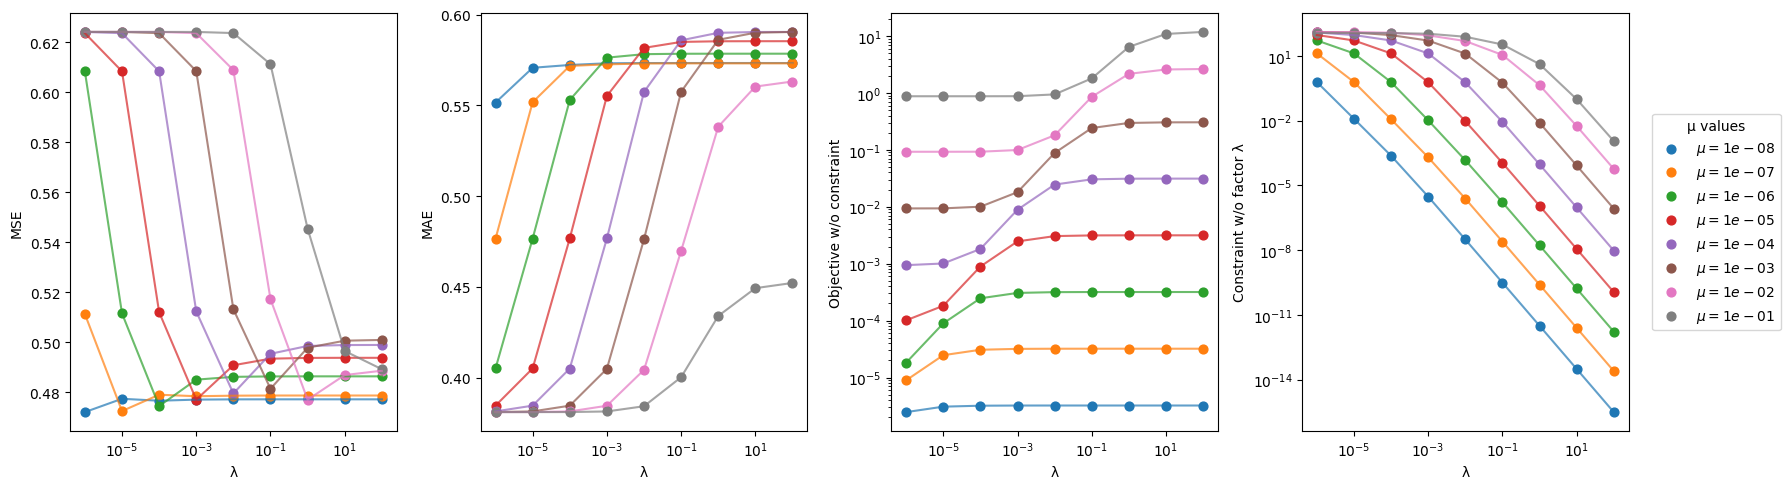

In [7]:
mus = np.array([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
lambds = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2])
rhs = D.conj().T @ d

K_op_closed = np.empty((mus.shape[0], lambds.shape[0]), dtype=object)
x_1_closed_form = np.zeros((mus.shape[0], lambds.shape[0], rhs.shape[0]), dtype=np.complex128)
for i_mu, mu_val in enumerate(mus):
    for j_lambd, lambd_val in enumerate(lambds):
        K_op_closed[i_mu, j_lambd] = (
            D.conj().T @ D
            + lambd_val * (E_star @ E)
            + mu_val * sp.eye(I * L + P)
        )
        x_1_closed_form[i_mu, j_lambd] = sp.linalg.spsolve(K_op_closed[i_mu, j_lambd], rhs)

# Metrics
m_pred = x_1_closed_form[:, :, -P:]
mse = mse(m, m_pred)
mae = mae(m, m_pred)

def J_1_parameters_without_constraint(x, lambd, mu):
    Dx_minus_d = D @ x - d
    return (
        0.5 * np.vdot(Dx_minus_d, Dx_minus_d).real
        + 0.5 * mu * np.vdot(x, x).real
    )
objective_without_constraint = np.array([
    [
        J_1_parameters_without_constraint(x_1_closed_form[i, j], lambds[j], mus[i])
        for j in range(len(lambds))
    ]
    for i in range(len(mus))
])

def constraint_parameters(x, lambd):
    Ex = E @ x
    return np.vdot(Ex, Ex).real
constraint = np.array([
    [
        constraint_parameters(x_1_closed_form[i, j], lambds[j])
        for j in range(len(lambds))
    ]
    for i in range(len(mus))
])

# Plotting
fig, axs = plt.subplots(1, 4, figsize=(18, 5))

for i_mu, mu_val in enumerate(mus):
    label = f"$\\mu={mu_val:.0e}$"
    axs[0].scatter(lambds, mse[i_mu], label=label, s=40)
    axs[0].plot(lambds, mse[i_mu], linestyle='-', alpha=0.7)
    axs[1].scatter(lambds, mae[i_mu], label=label, s=40)
    axs[1].plot(lambds, mae[i_mu], linestyle='-', alpha=0.7)
    axs[2].scatter(lambds, objective_without_constraint[i_mu], label=label, s=40)
    axs[2].plot(lambds, objective_without_constraint[i_mu], linestyle='-', alpha=0.7)
    axs[3].scatter(lambds, constraint[i_mu], label=label, s=40)
    axs[3].plot(lambds, constraint[i_mu], linestyle='-', alpha=0.7)

axs[2].set_yscale("log")
axs[3].set_yscale("log")
for ax in axs:
    ax.set_xlabel("λ")
    ax.set_xscale("log")
axs[3].legend(
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    title="μ values"
)

axs[0].set_ylabel("MSE")
axs[1].set_ylabel("MAE")
axs[2].set_ylabel("Objective w/o constraint")
axs[3].set_ylabel("Constraint w/o factor λ")

plt.tight_layout()
plt.show()

2025-09-13 20:54:20 - iwp - INFO - Started μ=1e-08 for a maximum of 30000 iterations.
2025-09-13 20:58:15 - iwp - INFO - Stopped after 30000 iterations in 235.055 seconds with 465.51 KB memory used.
2025-09-13 20:58:16 - iwp - INFO - Started μ=1e-07 for a maximum of 30000 iterations.
2025-09-13 21:02:10 - iwp - INFO - Stopped after 30000 iterations in 233.867 seconds with 426.13 KB memory used.
2025-09-13 21:02:10 - iwp - INFO - Started μ=1e-06 for a maximum of 30000 iterations.
2025-09-13 21:06:04 - iwp - INFO - Stopped after 30000 iterations in 233.862 seconds with 413.41 KB memory used.
2025-09-13 21:06:05 - iwp - INFO - Started μ=1e-05 for a maximum of 30000 iterations.
2025-09-13 21:10:00 - iwp - INFO - Stopped after 30000 iterations in 235.150 seconds with 500.87 KB memory used.
2025-09-13 21:10:00 - iwp - INFO - Started μ=1e-04 for a maximum of 30000 iterations.
2025-09-13 21:13:54 - iwp - INFO - Stopped after 30000 iterations in 234.052 seconds with 420.28 KB memory used.
2025-

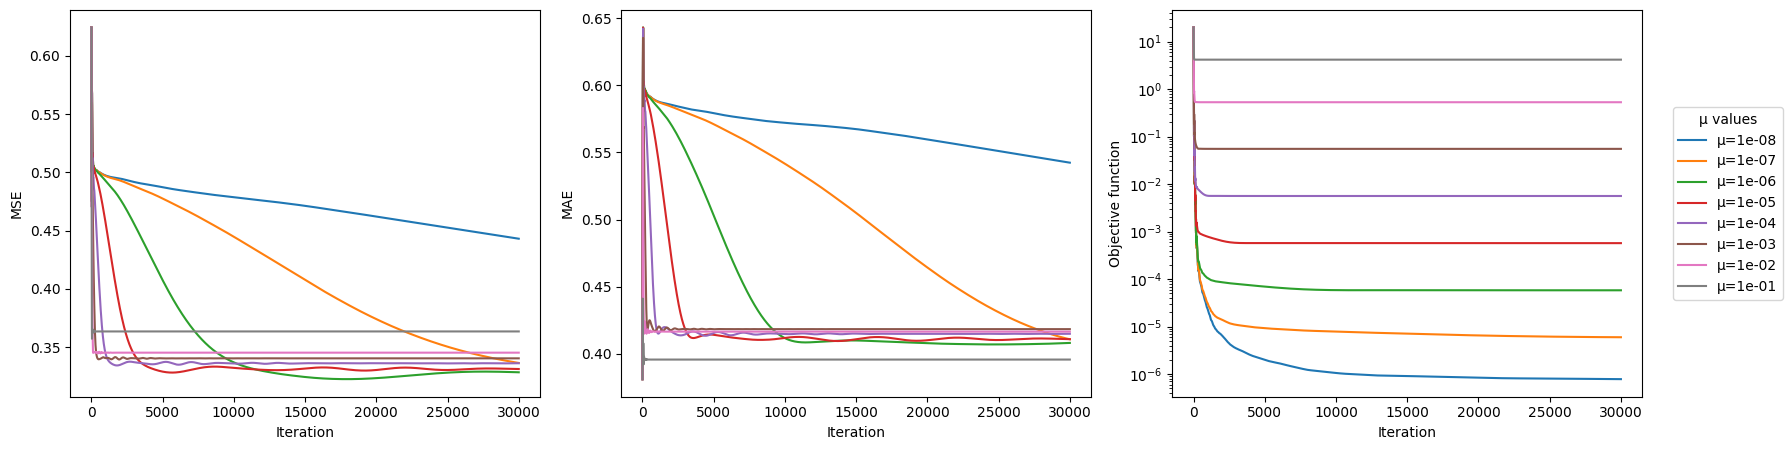

In [6]:
algo_list = []
x_list = []

x_0 = np.zeros(I * L + P, dtype=np.complex128)  # shape: (I*L + P,)
for mu_val in mus:
    K_op_J_2 = D.conj().T @ D + mu_val * sp.eye(I * L + P)
    K_eigenvalues_J_2 = np.linalg.eigvals(K_op_J_2.toarray())
    K_J_2 = np.max(np.abs(K_eigenvalues_J_2))

    def J_2_mu(x, threshold=1e-6, mu=mu_val):
        Dx_minus_d = D @ x - d
        Ex = E @ x
        if np.linalg.norm(Ex) < threshold:
            return (
                0.5 * np.vdot(Dx_minus_d, Dx_minus_d).real
                + 0.5 * mu * np.vdot(x[-P:], x[-P:]).real
            )
        else:
            return np.inf

    def grad_J_2_mu(x, mu=mu_val):
        reg = np.zeros_like(x)
        reg[-P:] = mu * x[-P:]
        return D_star @ (D @ x - d) + reg

    algo = FISTA(
        exp_name=args.exp_name,
        algo_plot_name=f"μ={mu_val:.0e}",
        f=J_2_mu,
        grad=grad_J_2_mu,
        prox=prox_J_2,
        K=K_J_2,
        logger=logger,
        verbose=verbose,
    )
    x = algo.run(x0=x_0, max_iterations=30000)
    algo.plot_algorithm_convergence(m, args.visuals_path, show=False, save=False)
    algo_list.append(algo)
    x_list.append(x)

plot_all_algorithms_convergence(
    algorithms=algo_list,
    visuals_path=args.visuals_path,
    show=True,
    save=False,
    show_time_memory=False,
)

2025-09-13 20:42:23 - iwp - INFO - Started μ=1e-08 for a maximum of 3000 iterations.
2025-09-13 20:42:41 - iwp - INFO - Converged after 2341 iterations in 18.492 seconds with 146.01 KB memory used.
2025-09-13 20:42:42 - iwp - INFO - Started μ=1e-07 for a maximum of 3000 iterations.
2025-09-13 20:43:00 - iwp - INFO - Converged after 2335 iterations in 18.301 seconds with 118.92 KB memory used.
2025-09-13 20:43:01 - iwp - INFO - Started μ=1e-06 for a maximum of 3000 iterations.
2025-09-13 20:43:17 - iwp - INFO - Converged after 2150 iterations in 16.569 seconds with 109.44 KB memory used.
2025-09-13 20:43:18 - iwp - INFO - Started μ=1e-05 for a maximum of 3000 iterations.
2025-09-13 20:43:33 - iwp - INFO - Converged after 1938 iterations in 15.323 seconds with 188.55 KB memory used.
2025-09-13 20:43:33 - iwp - INFO - Started μ=1e-04 for a maximum of 3000 iterations.
2025-09-13 20:43:45 - iwp - INFO - Converged after 1441 iterations in 11.307 seconds with 117.95 KB memory used.
2025-09-13

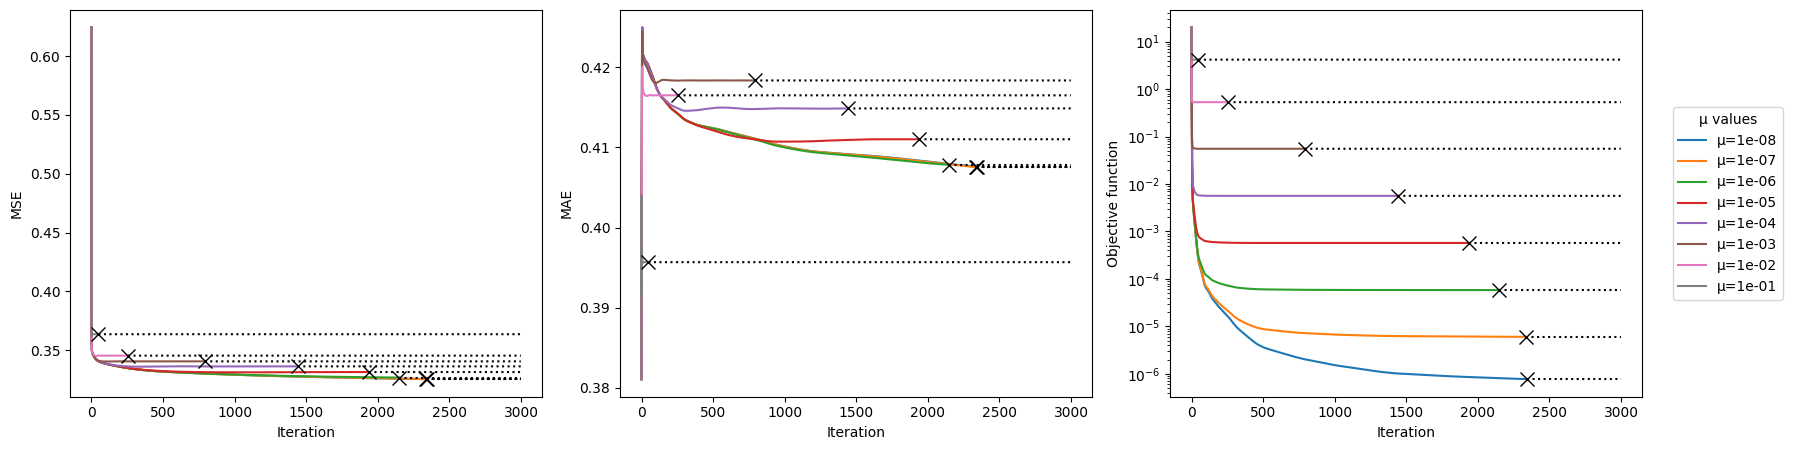

In [5]:
algo_list = []
x_list = []

x_0 = np.zeros(I * L + P, dtype=np.complex128)  # shape: (I*L + P,)
for mu_val in mus:
    K_op_J_3 = sum(
        B_i.conj().T @ Ainv.conj().T @ C.conj().T @ C @ Ainv @ B_i for B_i in B_list
    ) + mu * sp.eye(P)
    K_eigenvalues_J_3 = np.linalg.eigvals(K_op_J_3.toarray())
    K_J_3 = np.max(np.abs(K_eigenvalues_J_3))

    def J_3(m, mu=mu_val):
        total = 0.0
        for i in range(I):
            CA_inv_Bi_m = C @ sp.linalg.spsolve(A, B_list[i] @ m)
            diff = CA_inv_Bi_m - d_list[i]
            total += 0.5 * np.vdot(diff, diff).real
        return total + 0.5 * mu * np.vdot(m, m).real

    def dJ_3(m, mu=mu_val):
        p_sum = sum(
            B_i.conj().T
            @ sp.linalg.spsolve(
                A_star,
                C_star @ (C @ sp.linalg.spsolve(A, B_i @ m) - d_i),
            )
            for B_i, d_i in zip(B_list, d_list)
        )
        return p_sum + mu * m

    algo = NesterovAcceleratedGradientDescent(
        exp_name=args.exp_name,
        algo_plot_name=f"μ={mu_val:.0e}",
        f=J_3,
        df=dJ_3,
        K=K_J_3,
        logger=logger,
        verbose=verbose,
    )
    x = algo.run(x0=x_0[-P:], max_iterations=3000)
    algo.plot_algorithm_convergence(m, args.visuals_path, show=False, save=False)
    algo_list.append(algo)
    x_list.append(x)

plot_all_algorithms_convergence(
    algorithms=algo_list,
    visuals_path=args.visuals_path,
    show=True,
    save=False,
    show_time_memory=False,
)

In [60]:
pred_m = x_5[-P:]
print(os.path.join(args.data_path, "PredictedVectorm.dat"))
save_complex_vector(os.path.join(args.data_path, "PredictedVectorm.dat"), pred_m)

../../data/data_backup/PredictedVectorm.dat


In [23]:
for i in range(I):
    u_i = Ainv @ (B_list[0] @ x_3[-P:])
    print(np.linalg.norm(C @ u_i - d_list[0]))

print(J_2(x_3))
print(J_3(x_3[-P:]))

print(J_3(m))
print(J_3(m) - 0.5 * mu * np.vdot(m, m).real)

3.28773953535e-05
3.28773953535e-05
9.28572057634578e-09
9.285720576347379e-09
1.2296266850053244e-08
7.98593250583195e-20
